In [1]:
import pyvista as pv
from Kirchhoffpy import lenspy
from Kirchhoffpy import Feedpy
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from Kirchhoffpy import coordinate,field_storage
from Kirchhoffpy.Vopy import CO,dotproduct
c=299792458
mu=4*np.pi*10**(-7);
epsilon=8.854187817*10**(-12);
Z0=np.sqrt(mu/epsilon,dtype = np.float64)
p = pv.Plotter()
srffolder = 'srf2/'

In [2]:
# 1. define frequnecy and wavelength
freq = 90*10**9
Lambda = c*1000/freq
k = 2*np.pi/Lambda
print(Lambda,k)

3.3310273111111113 1.8862605197565134


In [3]:
# 2. define coordinate systems
coord_ref = coordinate.coord_sys([0,0,0],[0,0,0],axes = 'xyz')

coord_L1 = coordinate.coord_sys([0,0,-(844.621988-4.34990822154231*10)],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)

coord_feed = coordinate.coord_sys([0,0,0],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)

coord_sky = coordinate.coord_sys([0,0,0],[np.pi,0,0],axes = 'xyz',ref_coord = coord_ref)

In [4]:
# 3. define input Feedhorn
feed= Feedpy.GaussiBeam(-8,8,
                        k,
                        coord_feed,
                        polarization = 'x')

7.787540624053921e+80


In [5]:
# 4. Lenses and aperture 
L1 = lenspy.simple_Lens(3.36,
                        4.34990822154231*10,# Thickness
                        44.3704085511817*10, # diameter
                        srffolder + 'lens1_f2.rsf', 
                        srffolder + 'lens1_f1.rsf',
                        p,
                        coord_L1,
                        name = 'L1',
                        outputfolder = 'output/')
#L2 = lenspy.simple_Lens(2,46.9671 ,400, srffolder + 'lens2_f1.rsf', srffolder + 'lens2_f2.rsf',p,[0,0,-227.64396727901004],name = 'L2')
#L3 = lenspy.simple_Lens(2,29.6556 ,400, srffolder + 'lens3_f1.rsf', srffolder + 'lens3_f2.rsf',p,[0,0,-71.77590111674095],name = 'L3')

In [6]:
# 5. fiedl storage
center_grd = field_storage.Spherical_grd(coord_sky,
                                         0,
                                         0,
                                         20,
                                         20,
                                         501,501,
                                         Type = 'ELoverAz', 
                                         far_near = 'far',
                                         distance = 50000)

In [7]:

N1 =[380,1360]
N2 = [380,150]
L1.PO_analysis(#[400,1,400,1],
               [1,N1[0],N1[1],1],
               [1,N2[0],N2[1],1],
               #[5,N2[0],N2[1],1],
            feed,k,
            sampling_type_f1='polar',
            phi_type_f1 = 'less',
            sampling_type_f2='polar',
            phi_type_f2 = 'less',
            po_name = '_po_cur_0mm_x.h5',
            Method ='POPO')


Gain of the Guassian feedhonr!
5.501130783487707 dB
12.56897216538291
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
input power
poynting value max!
0.00016578127777603716
12.547727773739755
******
cores: 132


100%|█████████████████████████████████████████| 285/285 [01:50<00:00,  2.59it/s]


Transform f1
poynting value max!
0.00011720921920026858
8.86305333049912
f2
poynting value max!
0.00010902241831646682
8.826156171711899
f2 transmission
poynting value max!
6.269487759327995


In [8]:
center_grd.grid.x = center_grd.grid.x.ravel()
center_grd.grid.y = center_grd.grid.y.ravel()
center_grd.grid.z = center_grd.grid.z.ravel()
print(center_grd.grid.z.size)

251001


In [9]:
#L1.surf_cur_file = 'output/L1_po_cur_0mm_x.h5'

L1.source(center_grd,
          k,
          far_near = 'far')

cores: 1551


100%|█████████████████████████████████████████| 161/161 [00:14<00:00, 10.88it/s]


In [10]:
r, theta, phi = center_grd.coord_sys._toSpherical(center_grd.grid.x,center_grd.grid.y,center_grd.grid.z)
co,cx,crho = CO(theta,phi)
E_co = dotproduct(center_grd.E,co)
E_cx = dotproduct(center_grd.E,cx)

In [11]:
cx.x

array([-0.01507508, -0.01501448, -0.01495388, ..., -0.01495388,
       -0.01501448, -0.01507508])

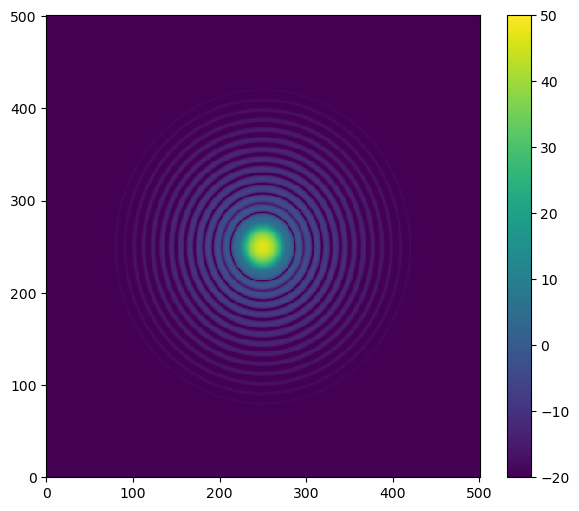

In [12]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(E_co.reshape(501,-1)))*20,vmax = 50, vmin = -20)
plt.colorbar()

In [13]:
import h5py as h5
def readh5(fname):
    name = fname.split('.')
    with h5.File(name[0]+'.h5','r') as f:
        co = f['co-polar'][:,:]
        cx = f['cx-polar'][:,:]
        Az = f['Az'][:]
        El = f['El'][:]
    return Az, El, co, cx

In [14]:
Az, El, grasp_co,grasp_cx = readh5('output/_H5/Lens1_POPO_nostop_GaussianBeam_force_farGHz.h5')

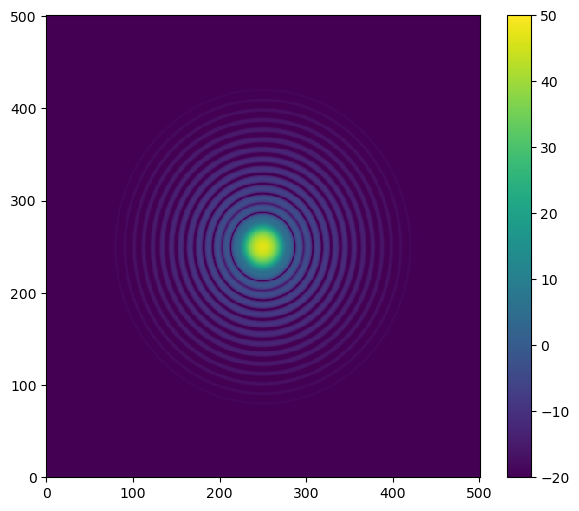

In [15]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(grasp_co.reshape(501,-1)))*20,vmax = 50, vmin = -20)
plt.colorbar()

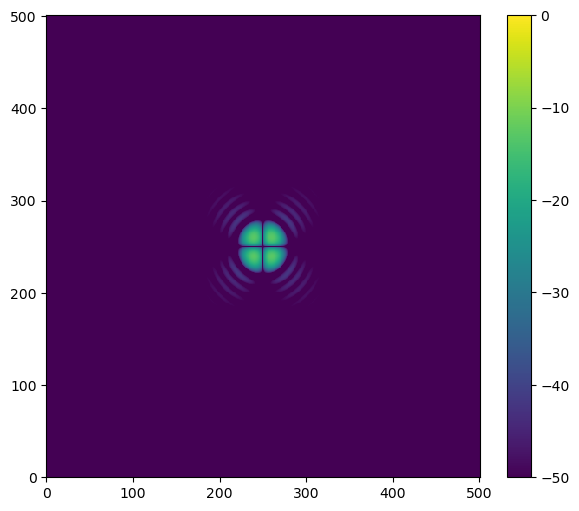

In [16]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(grasp_cx.reshape(501,-1)))*20,vmax = 0, vmin = -50)
plt.colorbar()

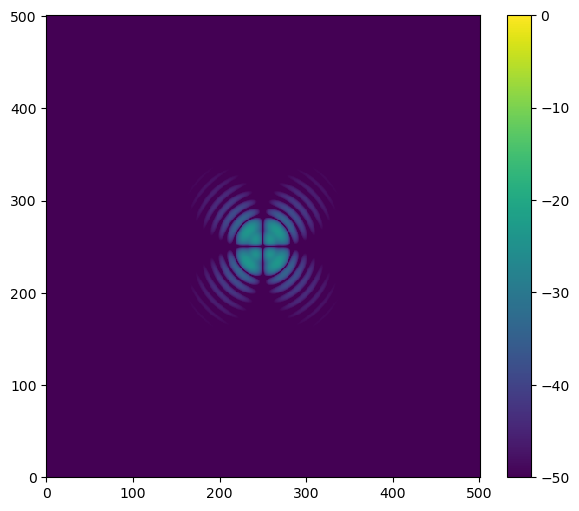

In [29]:
fig = plt.figure(figsize = (7,6))
plt.pcolor(np.log10(np.abs(E_cx.reshape(501,-1).T)**2)*10,vmax = 0, vmin = -50)
plt.colorbar()

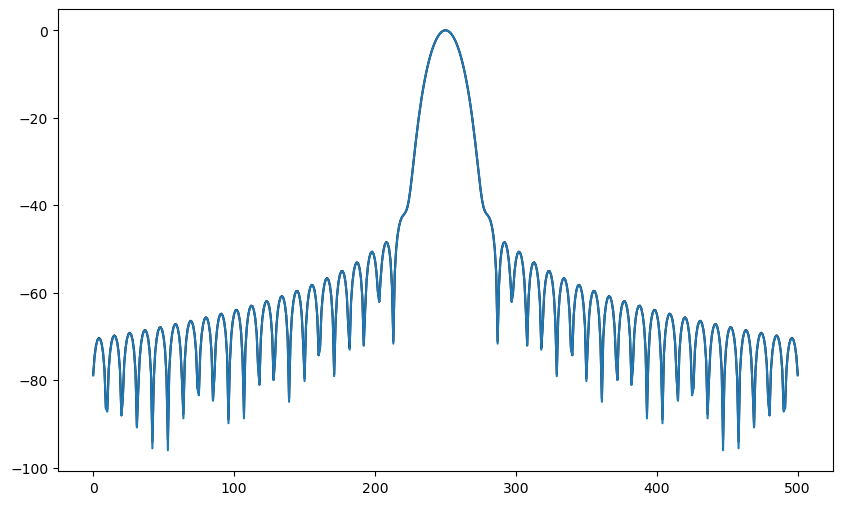

In [30]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:])/np.abs(grasp_co.reshape(501,-1)[250,:]).max())*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])/np.abs(E_co.reshape(501,-1)[250,:]).max())*20,'-')

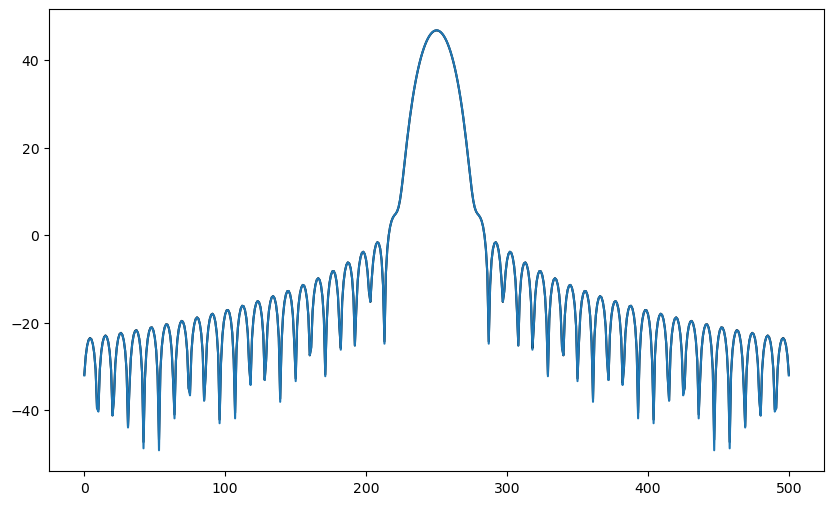

In [31]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')

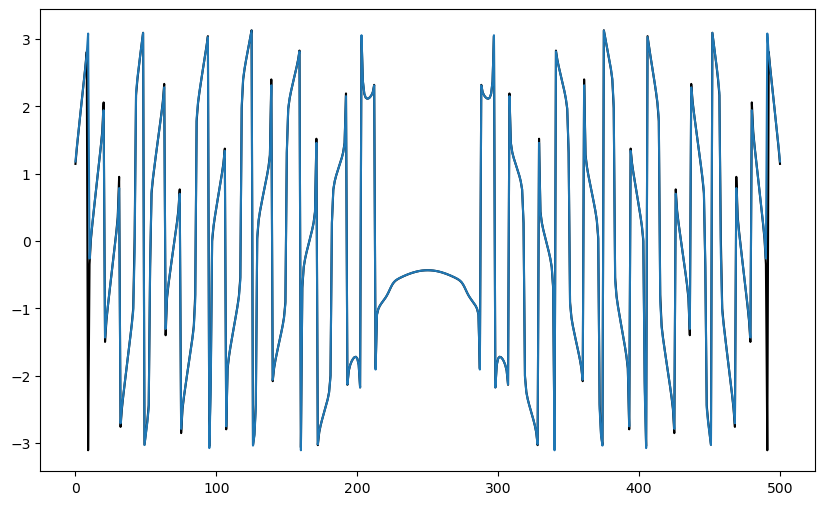

In [32]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.angle(grasp_co.reshape(501,-1)[250,:]/np.abs(grasp_co.reshape(501,-1)[250,:]).max()),'k-')
plt.plot(np.angle(E_co.reshape(501,-1)[250,:]/np.abs(E_co.reshape(501,-1)[250,:]).max()),'-')

In [33]:
ratio = np.abs(E_co.reshape(501,-1)[250,:]).max()*np.sqrt(4*np.pi/Z0)/k/np.abs(grasp_co.reshape(501,-1)[250,:]).max()
print(ratio)

0.09707642223332578


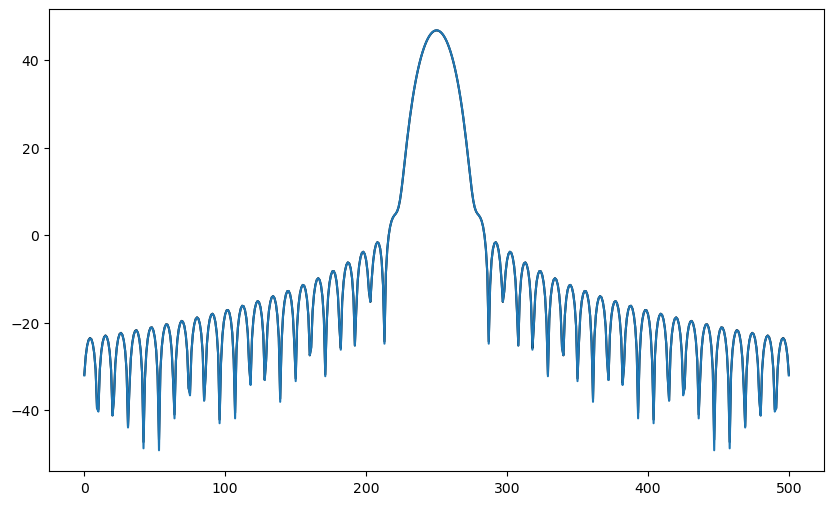

In [34]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')

In [35]:
G_co = grasp_co.reshape(501,-1)/grasp_co.reshape(501,-1)[250,250]
H_co = E_co.reshape(501,-1).T/E_co.reshape(501,-1)[250,250]

In [36]:
err = G_co-H_co

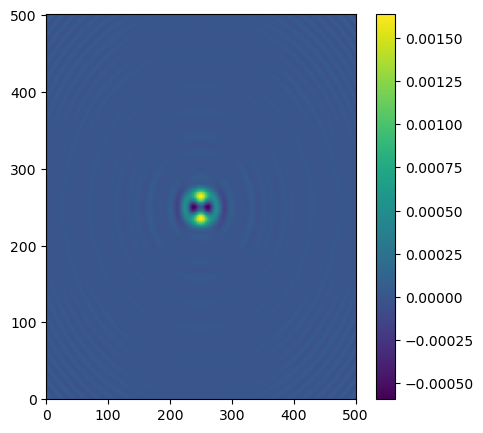

In [37]:
fig = plt.figure(figsize=(5,5))
plt.pcolor(err.real)
plt.colorbar()

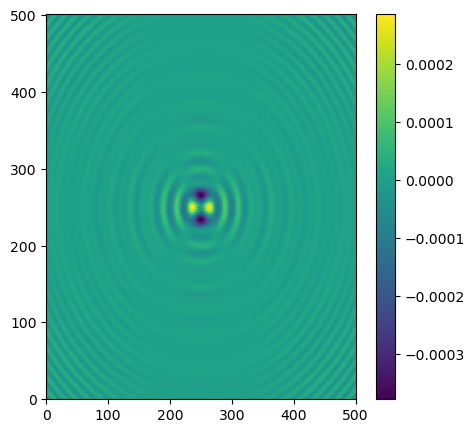

In [38]:
fig = plt.figure(figsize=(5,5))
plt.pcolor(err.imag)
plt.colorbar()

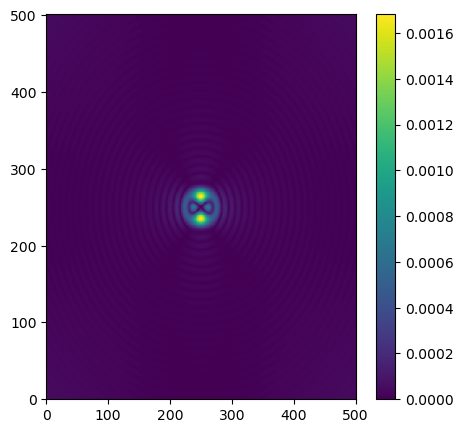

In [39]:
fig = plt.figure(figsize=(5,5))
plt.pcolor(np.abs(err))
plt.colorbar()

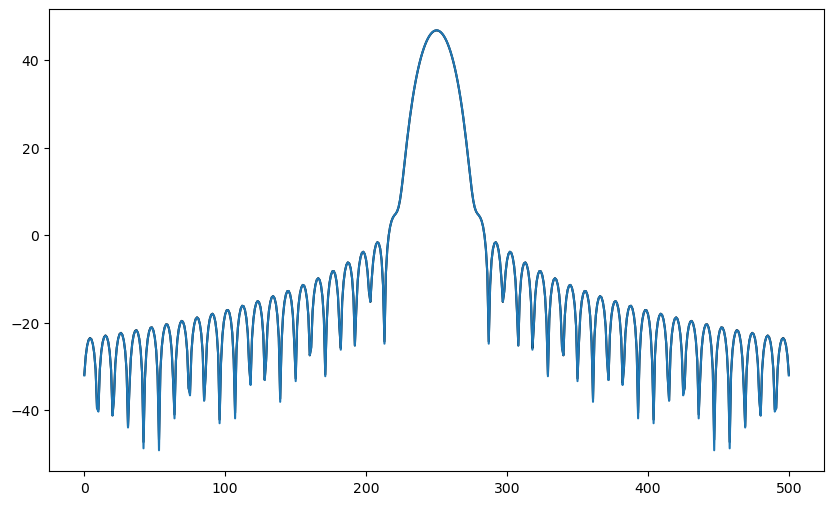

In [40]:
fig  =  plt.figure(figsize= (10,6))
plt.plot(np.log10(np.abs(grasp_co.reshape(501,-1)[250,:]))*20,'k-')
plt.plot(np.log10(np.abs(E_co.reshape(501,-1)[250,:])**2)*10,'-')